In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import json


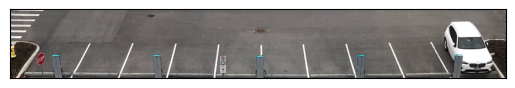

(523, 3767, 3)

In [2]:
img = cv2.imread("floor5_crop.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()
img.shape


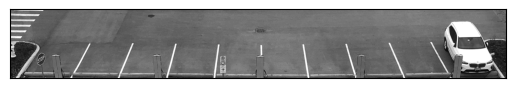

In [3]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap = "gray")
# plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.show()


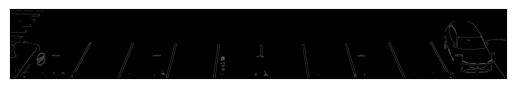

In [4]:
img_edge = cv2.Canny(img, 400, 500, apertureSize=3)
plt.imshow(img_edge, cmap = "gray")
plt.xticks([])
plt.yticks([])
plt.show()


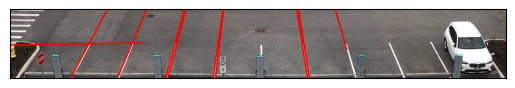

In [5]:
img_hough = img.copy()

lines = cv2.HoughLines(img_edge, rho=1, theta=np.pi/180, threshold=140)
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)
    cv2.line(img_hough, (x1,y1), (x2,y2), (0,0,255), 10)

plt.imshow(cv2.cvtColor(img_hough, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()


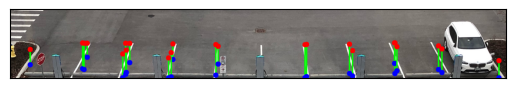

[[153, 1], [566.3333333333334, 3], [872.3333333333334, 3], [909, 1], [1221.6666666666667, 3], [1571.5, 2], [2246.0, 2], [2589.5, 2], [2927.0, 3], [3267.0, 2], [3713, 1]]
[[153, 1], [566.3333333333334, 3], [881.5, 4], [-1, 1], [1221.6666666666667, 3], [1571.5, 2], [2246.0, 2], [2589.5, 2], [2927.0, 3], [3267.0, 2], [3713, 1]]
[[153, 1], [566, 3], [881, 4], [1221, 3], [1571, 2], [2246, 2], [2589, 2], [2927, 3], [3267, 2], [3713, 1]]


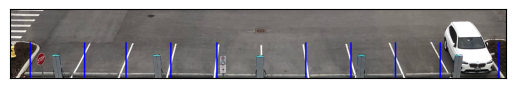

[[153, 1], [566, 3], [881, 4], [1221, 3], [1571, 2], [1908, 1], [2246, 2], [2589, 2], [2927, 3], [3267, 2], [3713, 1]]


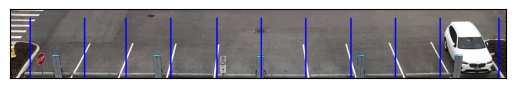

In [6]:
img_hough_p = img.copy()

lines = cv2.HoughLinesP(img_edge, rho=1, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
all_x = []  # (x_val, count)
y_min = sys.maxsize
y_max = 0
for line in lines:
    x1, y1, x2, y2 = line[0].tolist()
    # x1 = int(x1)
    # x2 = int(x2)
    # y1 = int(y1)
    # y2 = int(y2)

    # only want vertical lines
    if abs(y1 - y2) < 10:
        continue

    y1, y2 = min(y1, y2), max(y1, y2)
    y_min = min(y_min, y1)
    y_max = max(y_max, y2)

    # get vertical lines for rectangle
    x = int((x1+x2)/2)

    cv2.line(img_hough_p, (x,y1), (x,y2), (0,255,0), 10)
    cv2.circle(img_hough_p, (x,y1), radius=20, color=(0, 0, 255), thickness=-1)
    cv2.circle(img_hough_p, (x,y2), radius=20, color=(255, 0, 0), thickness=-1)

    found = False
    for p in all_x:
        x_val, count = p
        if abs(x_val - x) < 50:
            p[0] = (x_val * count + x) / (count + 1)
            p[1] += 1
            found = True
            break
    if not found:
        all_x.append([x, 1])

plt.imshow(cv2.cvtColor(img_hough_p, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

# clean up densed x_val
all_x.sort(key = lambda x: x[0])
print(all_x)
for i in range(len(all_x)):
    for j in range(i+1, len(all_x)):
        if abs(all_x[i][0] - all_x[j][0]) < 50:
            all_x[i][0] = (all_x[i][0] * all_x[i][1] + all_x[j][0] * all_x[j][1]) / (all_x[i][1] + all_x[j][1])
            all_x[i][1] = all_x[i][1] + all_x[j][1]
            all_x[j][0] = -1
            all_x[j][1] = 1  # avoid division by 0
print(all_x)

# remove useless x_val
i = 0
while True:
    if i >= len(all_x):
        break
    if all_x[i][0] == -1:
        all_x.pop(i)
    else:
        all_x[i][0] = int(all_x[i][0])
        i += 1

print(all_x)

img_condensed = img.copy()
for x, count in all_x:
    cv2.line(img_condensed, (int(x),y_min), (int(x),y_max), (255,0,0), 10)

plt.imshow(cv2.cvtColor(img_condensed, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()

# cars look further away from plarking slot lines from this angle
y_min = int(y_min - 0.7 * (y_max - y_min))
# add the middle line that's blocked by charging station
all_x.insert(5, [int((all_x[4][0] + all_x[5][0]) / 2), 1])
print(all_x)

img_mod = img.copy()
for x, count in all_x:
    cv2.line(img_mod, (x,y_min), (x,y_max), (255,0,0), 10)

plt.imshow(cv2.cvtColor(img_mod, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()


In [7]:
data = {
    "y_min": y_min,
    "y_max": y_max,
    "x": all_x
}

with open("coordinates.json", "w") as f:
    json.dump(data, f)
    # f.write(json.dumps(data))
